# TD 5: Molécule de benzène

Author: Sacha Guerrini

Dans la feuille de TD 5, nous nous sommes intéressés à la molécule de benzène $C_6H_6$. Nous avons étudié la dynamique des électrons libres capables de se déplacer d'un atome de carbone à l'autre par effet tunnel. Nous avions trouvé que les valeurs et kets propres du Hamiltonien était les suivants:

\begin{align*}
r_k &= \exp \left(\frac{2 i k \pi}{6} \right)\\
|r_k \rangle &= \frac{1}{\sqrt{6}} \underset{n=1}{\overset{6}{\sum}}\exp \left( \frac{2 i k\pi}{6}(n-1)\right)|n\rangle
\end{align*}

où $\{|n \rangle \}_{n \in \llbracket 1,6 \rrbracket}$ est la base canonique de l'espace de Hilbert de dimension 6 indiquant un état dans lequel l'électron est localisé autour de l'atome de carbone numéroté $n$.

Dans ce notebook, on propose de visualiser une partie des résultats établis pendant le TD afin d'en apporter une représentation visuelle. Nous considérerons d'abord la dynamique d'un état stationnaire, avant d'en étudier la superposition étudiée en cours.

In [176]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import astropy.units as u
import astropy.constants as const
from tqdm import tqdm

L'expression des $| r_k \rangle$ rappelée ci-dessus définie une matrice de passage des vecteurs de la base $\{|n \rangle\}$ vers la base $\{ |r_k \rangle \}$. Implémentons là à l'aide de `numpy`.

In [134]:
P = np.array([
    [1/np.sqrt(6)*np.exp(1j*2*np.pi*k/6*(n-1)) for k in range(6)]
for n in range(6)], dtype=np.complex128)

print(P)

[[ 0.40824829+0.00000000e+00j  0.20412415-3.53553391e-01j
  -0.20412415-3.53553391e-01j -0.40824829-4.99959962e-17j
  -0.20412415+3.53553391e-01j  0.20412415+3.53553391e-01j]
 [ 0.40824829+0.00000000e+00j  0.40824829+0.00000000e+00j
   0.40824829+0.00000000e+00j  0.40824829+0.00000000e+00j
   0.40824829+0.00000000e+00j  0.40824829+0.00000000e+00j]
 [ 0.40824829+0.00000000e+00j  0.20412415+3.53553391e-01j
  -0.20412415+3.53553391e-01j -0.40824829+4.99959962e-17j
  -0.20412415-3.53553391e-01j  0.20412415-3.53553391e-01j]
 [ 0.40824829+0.00000000e+00j -0.20412415+3.53553391e-01j
  -0.20412415-3.53553391e-01j  0.40824829-9.99919924e-17j
  -0.20412415+3.53553391e-01j -0.20412415-3.53553391e-01j]
 [ 0.40824829+0.00000000e+00j -0.40824829+4.99959962e-17j
   0.40824829-9.99919924e-17j -0.40824829+1.49987989e-16j
   0.40824829-1.99983985e-16j -0.40824829+2.49979981e-16j]
 [ 0.40824829+0.00000000e+00j -0.20412415-3.53553391e-01j
  -0.20412415+3.53553391e-01j  0.40824829-1.99983985e-16j
  -0.2041

In [135]:
#On peut vérifier que si on applique P à un vecteur de la base canonique, on obtient un vecteur de r_k
n_0 = np.array([1, 0, 0, 0, 0, 0])

print(P @ n_0)

[0.40824829+0.j 0.40824829+0.j 0.40824829+0.j 0.40824829+0.j
 0.40824829+0.j 0.40824829+0.j]


Considérons d'abord le cas simple des états stationnaires. Considérons par exemple l'état $|r_1 \rangle$ dont l'énergie propre est $E_0 - a$, alors l'opérateur d'évolution donne que:

$$
|r_1(t) \rangle = \exp\left(-\frac{i (E_0 - a)t}{\hbar} \right)|r_1 \rangle
$$

où $a=2.4$ eV. L'énergie $E_0$ n'a pas d'importance dans ce qui suit. On la prendra donc égale à 10 eV par défaut.

In [191]:
a = 2.4 #eV
E_0 = 10 #eV
spectrum = np.array([
    E_0 - 2*a,
    E_0 - a,
    E_0 + a,
    E_0 + 2*a,
    E_0 + a,
    E_0 - a
])
hbar = const.hbar.to(u.eV * u.s).value

def evol_r_t(t, r):
    #Définis les constantes avec les bonnes unités
    r = np.copy(r)
    for k in range(6):
        r[k] = np.exp(-1j * spectrum[k] * t / hbar) * r[k]
    return r

def get_proba_n(n, r):
    """
    Calcule la probabilité que l'électron soit autour d'un atome n sachant le vecteur d'état r dans la base des états stationnaires r_k
    """
    return (np.abs(np.linalg.inv(P) @ r)**2)[n]

In [206]:
#On calcule maintenant l'évolution temporelle de l'état
n_steps = 1000
t = np.linspace(0, 1e-15, n_steps)

r = np.array([1, 0, 0, 0, 0, 0], dtype=np.complex128) #On commence dans l'état r_0

probas = []

for i in tqdm(range(len(t))):
    r_i = evol_r_t(t[i], r)
    probas.append([get_proba_n(n, r_i) for n in range(6)])

probas = np.array(probas)

100%|██████████| 1000/1000 [00:00<00:00, 5868.95it/s]


In [207]:
#Et on plot!
def anim_plot(probas, n_steps, n_atoms, output_path):

    angles = np.linspace(0, 2*np.pi, n_atoms, endpoint=False)
    positions = np.array([np.cos(angles), np.sin(angles)]).T

    fig, ax = plt.subplots(figsize=(7,7))
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.axis('off')

    # Dessiner les lignes reliant les atomes
    for i in range(n_atoms):
        start = positions[i]
        end = positions[(i + 1) % n_atoms]  # Boucler sur le premier atome
        ax.plot([start[0], end[0]], [start[1], end[1]], color='black', lw=2, alpha=0.5)

    # Création des cercles pour les atomes
    circles = [plt.Circle(pos, 0.1, color='white', ec='black') for pos in positions]
    for circle in circles:
        ax.add_patch(circle)

    # Ajout des numéros d'atomes
    for i, (x, y) in enumerate(positions):
        if i in [0, 1, 5]:
            ax.text(x+0.2, y, 'C'+str(i), color='black', ha='center', va='center', fontsize=10, weight='bold')
        else:
            ax.text(x-0.2, y, 'C'+str(i), color='black', ha='center', va='center', fontsize=10, weight='bold')

    # Création de la barre de couleur
    norm = Normalize(vmin=0, vmax=1)
    sm = ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Probabilité', fontsize=12)

    ax.set_title('Probabilité de présence de l\'électron autour de chaque atome de carbone\n dans la molécule de benzène')

    text = ax.text(-1.4, 1.4, 'Time:', fontsize=12)
    # Fonction d'animation
    def update(frame):
        for prob, circle in zip(probas[frame], circles):
            circle.set_facecolor(sm.to_rgba(prob))
        text.set_text('Time: {:.2e} fs'.format(t[frame]*1e15))
        return circles

    # Création de l'animation
    ani = FuncAnimation(fig, update, frames=n_steps, interval=100, blit=True)

    plt.close(fig)  # Éviter l'affichage du graphique statique

    #save animation
    # Sauvegarde de l'animation en GIF
    writer = animation.PillowWriter(fps=60,
                                    metadata=dict(artist='Me'),
                                    bitrate=1800)
    ani.save(output_path, writer=writer)

    print('output_path:', output_path)

In [208]:
n_atoms = 6
output_path = 'benzene_etat_stationnaire.gif'
anim_plot(probas, n_steps, n_atoms, output_path)

output_path: benzene_etat_stationnaire.gif


In [210]:
from IPython.display import HTML

# Afficher le GIF avec HTML
HTML(f'<img src="{output_path}" style="width:50%;">')

On observe que l'électron est complètement délocalisé. La probabilité de l'observe autour d'un carbone $|n\rangle$ est constante au cours du temps. Intéressons nous maintenant à la superposition de deux états stationnaires comme dans le TD5:

$$
| \psi \rangle = \frac{1}{\sqrt{2}}(|r_0\rangle + |r_1 \rangle)
$$

In [199]:
#On calcule maintenant l'évolution temporelle de l'état
n_steps = 1000
t = np.linspace(0, 2e-15, n_steps)

r = 1/np.sqrt(2)*np.array([1, 1, 0, 0, 0, 0], dtype=np.complex128) #On commence dans l'état r_0 + r_1

probas = []

for i in tqdm(range(len(t))):
    r_i = evol_r_t(t[i], r)
    proba = [get_proba_n(n, r_i) for n in range(6)]
    assert np.isclose(np.sum(proba), 1)
    probas.append(proba)

probas = np.array(probas)

100%|██████████| 1000/1000 [00:00<00:00, 2610.79it/s]


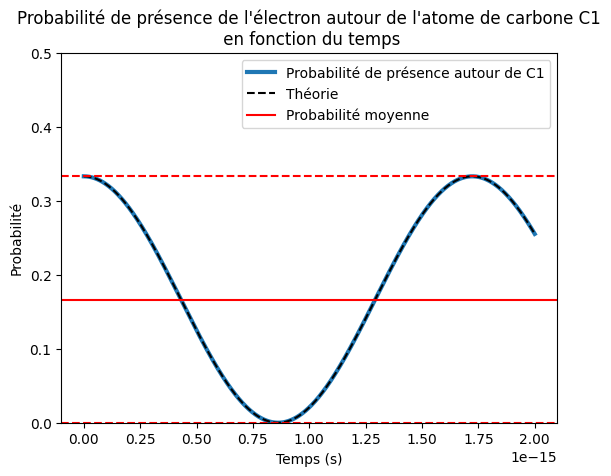

In [200]:
plt.figure()

plt.plot(t, probas[:, 0], label='Probabilité de présence autour de C1', lw=3)
theory = 1/6 + 1/6*np.cos(a*t/hbar)
plt.plot(t, theory, c='k', label='Théorie', ls='--')
plt.axhline(1/6, c='r', label='Probabilité moyenne')
plt.axhline(0, c='r', ls='--')
plt.axhline(1/3, c='r', ls='--')
plt.ylim(0, 1/2)
plt.xlabel('Temps (s)')
plt.ylabel('Probabilité')
plt.title('Probabilité de présence de l\'électron autour de l\'atome de carbone C1\n en fonction du temps')
plt.legend()

plt.show()

On peut d'abord vérifier le résultat obtenu dans le TD que la probabilité d'observer l'électron autour du carbone 1 suit une évolution sinusoïdale au cours du temps.

In [201]:
n_atoms = 6
output_path = 'benzene_superposition.gif'
anim_plot(probas, n_steps, n_atoms, output_path)

output_path: benzene_superposition.gif


In [202]:
# Afficher le GIF avec HTML
HTML(f'<img src="{output_path}" style="width:50%;">')

On voit ici que pour chaque carbone la probabilité d'y trouver l'électron oscille entre 0 et 1/3.

On peut voir alors la probabilité se propager entre les atomes de carbone. Regardons maintenant un état initialement localisé sur un atome de carbone, disons le carbone numéroté 0:

$$
|\psi \rangle = |0 \rangle
$$

In [203]:
t = np.linspace(0, 2e-15, n_steps)

r = P @ np.array([1, 0, 0, 0, 0, 0], dtype=np.complex128) #On commence dans l'état |0>

probas = []
for i in tqdm(range(len(t))):
    r_i = evol_r_t(t[i], r)
    probas.append([get_proba_n(n, r_i) for n in range(6)])

probas = np.array(probas)

100%|██████████| 1000/1000 [00:00<00:00, 5268.95it/s]


In [204]:
n_atoms = 6
output_path = 'benzene_start_0.gif'
anim_plot(probas, n_steps, n_atoms, output_path)

output_path: benzene_start_0.gif


In [205]:
# Afficher le GIF avec HTML
HTML(f'<img src="{output_path}" style="width:50%;">')

On peut voir la densité de probabilité se propager entre les atomes de carbone et interférer pour ponctuellement augmenter la probabilité de certains carbones (3 et 0). Cela met également en évidence le fait qu'un état $|n \rangle$ n'est pas un état stationnaire. C'est ce que l'on attend comme ces états ne sont pas des états propres du Hamiltonien considéré.